Processed data for mscoco2014.csv!
Processed data for hdr.csv!
Processed data for dalle-3.csv!
Processed data for dalle-2.csv!
Processed data for midjourney.csv!
Processed data for vqgan.csv!
Individual Accuracies per Model and Dataset:


,Model,Dataset,Accuracy
0,logits_Grag2021_progan,mscoco2014.csv,0.994
1,logits_Grag2021_latent,mscoco2014.csv,0.998
2,resnet50nodown_progan,mscoco2014.csv,0.984
3,resnet50nodown_stylegan2,mscoco2014.csv,0.998
4,aggregate,mscoco2014.csv,0.976
5,logits_Grag2021_progan,hdr.csv,1.000
6,logits_Grag2021_latent,hdr.csv,1.000
7,resnet50nodown_progan,hdr.csv,0.972
8,resnet50nodown_stylegan2,hdr.csv,1.000
9,aggregate,hdr.csv,0.972



Aggregated Accuracy across Models:


,Model,Accuracy
0,aggregate,0.821333
1,logits_Grag2021_latent,0.714333
2,logits_Grag2021_progan,0.449667
3,resnet50nodown_progan,0.510000
4,resnet50nodown_stylegan2,0.406833


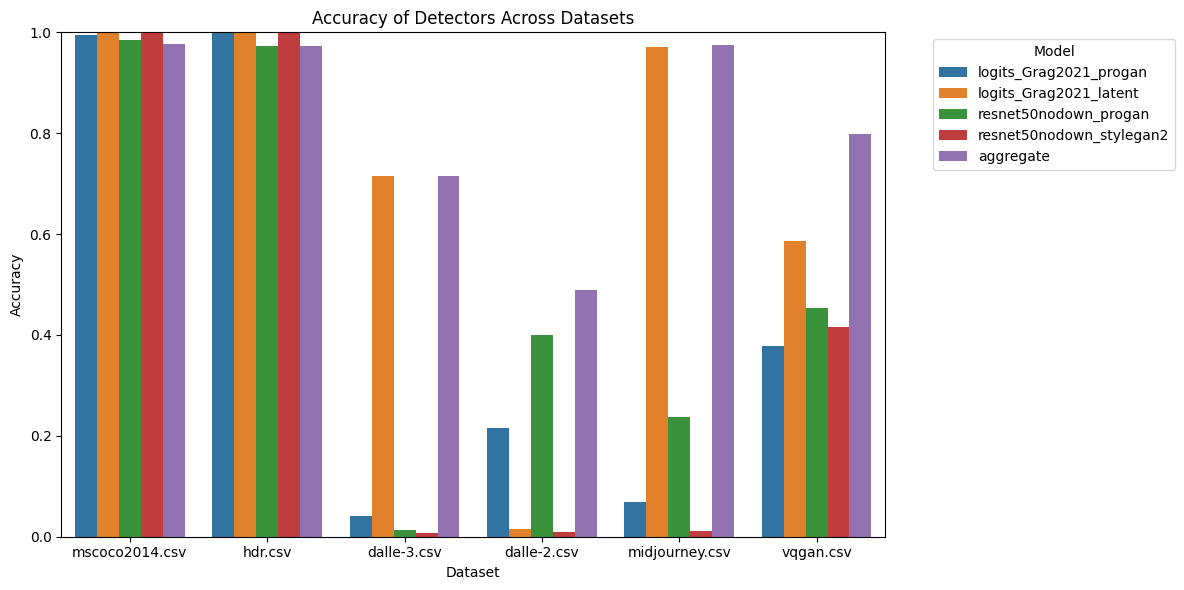

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from pathlib import Path

# Function to convert logits to probabilities using sigmoid
def logits_to_probabilities(logits):
    return 1 / (1 + np.exp(-logits))

def calculate_model_accuracy(df, threshold):
    accuracies = {}
    for model_name, column in model_columns.items():
        pred_column = f'{model_name}_pred'
        prob_column = f'{model_name}_prob' if 'exif' not in model_name else column
        df[pred_column] = df[prob_column] > threshold
        accuracies[model_name] = accuracy_score(df['true_label'], df[pred_column])

    # Aggregate results
    prediction_columns = [f'{model}_pred' for model in model_columns.keys()]
    df['final_pred'] = df[prediction_columns].any(axis=1)
    accuracies['aggregate'] = accuracy_score(df['true_label'], df['final_pred'])

    return accuracies

# List of CSV files for each dataset
csv_files = ['mscoco2014.csv', 'hdr.csv', 'dalle-3.csv', 'dalle-2.csv', 'midjourney.csv', 'vqgan.csv']  # Add your dataset CSV file names here
# accuracy_across_datasets = {model: [] for model in ['logits_Grag2021_progan', 'logits_Grag2021_latent', 'resnet50nodown_progan', 'resnet50nodown_stylegan2', 'exif_model', 'aggregate']}
accuracy_across_datasets = {model: [] for model in ['logits_Grag2021_progan', 'logits_Grag2021_latent', 'resnet50nodown_progan', 'resnet50nodown_stylegan2', 'aggregate']}

# Define the threshold for considering an image as synthetic
probability_threshold = 0.2

# Loop through each CSV file
for csv_file_name in csv_files:
    input = Path("..", "csv", csv_file_name)  # Adjust the path as necessary

    # Load the data from the CSV file
    df = pd.read_csv(input)

    # Applying sigmoid function to convert logits to probabilities
    model_columns = {
        'logits_Grag2021_progan': 'dMDetectorResultsinferenceResults_logits_Grag2021_progan',
        'logits_Grag2021_latent': 'dMDetectorResultsinferenceResults_logits_Grag2021_latent',
        'resnet50nodown_progan': 'gANDetectorResultsinferenceResults_logits_gandetection_resnet50nodown_progan',
        'resnet50nodown_stylegan2': 'gANDetectorResultsinferenceResults_logits_gandetection_resnet50nodown_stylegan2',
        # 'exif_model': 'exifDetectorResultsinferenceResults_isSyntheticImage'
    }

    for model_name, column in model_columns.items():
        if 'exif' not in model_name:  # Exif model doesn't need conversion
            df[f'{model_name}_prob'] = logits_to_probabilities(df[column])

    # Calculate model accuracy
    model_accuracies = calculate_model_accuracy(df, probability_threshold)

    # Store accuracies for each model across datasets
    for model, acc in model_accuracies.items():
        accuracy_across_datasets[model].append(acc)

    print(f"Processed data for {csv_file_name}!")

# Creating a DataFrame for accuracies across datasets
accuracy_across_df = pd.DataFrame.from_dict(accuracy_across_datasets, orient='index', columns=csv_files)
accuracy_across_df = accuracy_across_df.reset_index().melt(id_vars='index', var_name='Dataset', value_name='Accuracy')
accuracy_across_df.rename(columns={'index': 'Model'}, inplace=True)

# Print a readable table for individual accuracy
print("Individual Accuracies per Model and Dataset:")
display(accuracy_across_df)

# Calculate and print the aggregated accuracy across models
aggregated_accuracy_df = accuracy_across_df.groupby('Model')['Accuracy'].mean().reset_index()
print("\nAggregated Accuracy across Models:")
display(aggregated_accuracy_df)

# Plotting Accuracy Across Datasets
plt.figure(figsize=(12, 6))
sns.barplot(x='Dataset', y='Accuracy', hue='Model', data=accuracy_across_df)
plt.title('Accuracy of Detectors Across Datasets')
plt.xlabel('Dataset')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
